# How to get an elevation map?

An elevation map shows you elevations data with color.  The color doesn't reflect the natural landscape (it is not a satellite map), but all the points at a certain altitude have the same color.  Sometimes, contour lines are added at regular altitude interval to show the steepness: if two lines are close from each other, the slope is steep.

<table>
   <tr>
      <td><a href="samples/public/saint_helens.jpg"><img src="samples/public/saint_helens_thumb.jpg" target="_blank" width="300px"></a></td>
      <td><a href="samples/public/vesuvius.jpg"><img src="samples/public/vesuvius_thumb.jpg" target="_blank" width="300px"></a></td>
   </tr>
</table>


In this notebook, we will use data from NASA to make elevation maps like these:

<table>
   <tr>
      <td><a href="samples/public/naples.jpg"><img src="samples/public/naples_thumb.jpg" target="_blank" width="300px"></a></td>
      <td><a href="samples/public/peloponese.jpg"><img src="samples/public/peloponese_thumb.jpg" target="_blank" width="300px"></a></td>
   </tr>
   <tr>
      <td><a href="samples/public/reunion.jpg"><img src="samples/public/reunion_thumb.jpg" target="_blank" width="300px"></a></td>
      <td><a href="samples/public/tahoe.jpg"><img src="samples/public/tahoe_thumb.jpg" target="_blank" width="300px"></a></td>
   </tr>
   <tr>
      <td><a href="samples/public/crete.jpg"><img src="samples/public/crete_thumb.jpg" target="_blank" width="300px"></a></td>
      <td><a href="samples/public/honolulu.jpg"><img src="samples/public/honolulu_thumb.jpg" target="_blank" width="300px"></a></td>
   </tr>
   <tr>
      <td><a href="samples/public/hawaii.jpg"><img src="samples/public/hawaii_thumb.jpg" target="_blank" width="300px"></a></td>
      <td><a href="samples/public/martinique.jpg"><img src="samples/public/martinique_thumb.jpg" target="_blank" width="300px"></a></td>
   </tr>
</table>


# How to use this notebook?

You just need to read the indications, set some variables (but you can keep the default values if you want) and execute the cells.

Some cells will download data from the NASA website, some others will build LandSerf scripts.  To execute these scripts, all you need to do is copy them to the [LandSerf](http://www.staff.city.ac.uk/~jwo/landserf/) interface, and then click on the button `run`. LandSerf is a program that you can freely [download](http://www.staff.city.ac.uk/~jwo/landserf/download/).  It runs on Windows, Linux and Mac.  All the details will be provided below.

After running all the cells and excute the LandSerf scripts, you will have a nice relief map, as the one shown above!

---

A note about the NASA data.  We will use [SRTM data](https://dds.cr.usgs.gov/srtm/version2_1/Documentation/SRTM_Topo.pdf):

> The SRTM data sets result from a collaborative effort by the National Aeronautics and Space Administration (NASA) and the National Geospatial-Intelligence Agency (NGA - previously known as the National Imagery and Mapping Agency, or NIMA), as well as the participation of the German and Italian space agencies, to generate a near-global digital elevation model (DEM)

---

If you want to read the raw data from NASA, and get an image out of them without LandSerf, check out [this other repository of mine: `hgt2pnm`](https://github.com/boberle/hgt2pnm).

# Get the tile list

The following cells compute the list of tiles you need to download from the NASA website.

First, you need to draw a rectangle on a map and find the latitude and longitude of each edge.  You can use the [epsg.io](https://epsg.io/) website to find the values you need.

For example, for the island of Corsica, in Southern France, you get:
* North = 43N
* East = 9E
* West = 8E
* South = 41N

Then convert these into positive or negative integers:
* for latitude: N is positive, S is negative (for example 45S would be -45, so Australia is all negative),
* for longitude: E is positive, W is negative (so the US is all negative).

In [1]:
N = 43
E = 9
S = 41
W = 8

In [2]:
tile_list = set()

for lat in range(S, N+1) if S < N else range(N, S+1):
    lat = "%s%02d" % ("N" if lat >= 0 else "S", abs(lat))
    for long in range(E, W+1) if E < W else range(W, E+1):
        long = "%s%03d" % ("E" if long >= 0 else "W", abs(long))
        fn = "%s%s.hgt.zip" % (lat, long)
        print(fn)
        tile_list.add(fn)

N41E008.hgt.zip
N41E009.hgt.zip
N42E008.hgt.zip
N42E009.hgt.zip
N43E008.hgt.zip
N43E009.hgt.zip


# Download data from the NASA website

Now we need to download the data from the NASA website. But there is a catch: there is no tile if the tile is entirely covered by water (like seas, big lakes, etc.).  So we'll have to remove these from the tile list.

On the website, data are divided between SRTM1 (1 pixel is 1 meter) and SRTM3 (1 pixel is 3 meters): SRTM1 is just for US.

SRTM1 are divided into 7 US regions, each in its own directory, and SRTM3 into 6 continents, each in its own diretory. We can't know in advance in which directory a tile is, so we'll test them all until we find the tile data.

First, you need to choose: SRTM1 (US only) or SRTM3 (all the world):

In [3]:
TYPE = "SRTM3"

and a destination directory:

In [4]:
HGT_DIR = 'hgt_files_srtm3'

Note that the script doesn't download a tile if it is already here, in the `HGT_DIR`.

If you now the region, you can choose in the following set.  Otherwise, all regions will be tried.  Here are the choices:
* for SRTM1: `Region_01, Region_02, Region_03, Region_04, Region_05, Region_06, Region_07`
* for SRTM3: `Eurasia, Africa, Islands, North_America, South_America`

In [5]:
#REGION = [] # if you don't know
REGION = "Eurasia"

In [6]:
import os
import urllib
from zipfile import ZipFile
import io
from io import BytesIO


base_url = "https://dds.cr.usgs.gov/srtm/version2_1/"
regions = dict(
    SRTM1=["Region_01", "Region_02", "Region_03", "Region_04", "Region_05", "Region_06", "Region_07"],
    SRTM3=["Eurasia", "Africa", "Islands", "North_America", "South_America"],
)

if REGION:
    regions[TYPE] = [REGION]

found_tiles = set()

for tile in tile_list:
    
    print("Looking for '%s'..." % tile)
    
    hgt_fn = os.path.splitext(tile)[0]
    hgt_fpath = os.path.join(HGT_DIR, hgt_fn)
    if os.path.exists(hgt_fpath):
        print("'%s' already here, skipping..." % hgt_fpath)
        found_tiles.add(hgt_fn)
        continue
    
    found = False
    
    for region in regions[TYPE]:
        url = os.path.join(base_url, TYPE, region, tile)
        print("Trying '%s'... " % url, end="")
        
        """
        try:
            with ZipFile(io.BytesIO(urllib.request.urlopen(url).read())) as zf:
                fn = next(iter(zf.namelist()))
                fpath = zf.extract(fn, path=HGT_DIR) # HGT_DIR is create automatically
            print("OK")
            print("Saved in '%s'" % fpath)
            found = True
            break
        except urllib.error.URLError:
            print("not found")
        """
        
        
        # if the previous block doesn't work (download is hanging), try pycurl:
        import pycurl
        buffer = BytesIO()
        header = BytesIO()
        c = pycurl.Curl()
        c.setopt(c.URL, url)
        c.setopt(c.WRITEDATA, buffer)
        c.setopt(c.HEADERFUNCTION, header.write)
        c.perform()
        #input(len(buffer.getvalue()))
        #input(buffer.getvalue())
        if c.getinfo(pycurl.HTTP_CODE) == 404:
            print("not found")
        else:
            with ZipFile(buffer) as zf:
                fn = next(iter(zf.namelist()))
                fpath = zf.extract(fn, path=HGT_DIR) # HGT_DIR is create automatically
            print("OK")
            print("Saved in '%s'" % fpath)
            found = True
            break
        c.close()

        
    if found:
        found_tiles.add(hgt_fn)
        

Looking for 'N42E008.hgt.zip'...
Trying 'https://dds.cr.usgs.gov/srtm/version2_1/SRTM3/Eurasia/N42E008.hgt.zip'... OK
Saved in 'hgt_files_srtm3/N42E008.hgt'
Looking for 'N41E008.hgt.zip'...
Trying 'https://dds.cr.usgs.gov/srtm/version2_1/SRTM3/Eurasia/N41E008.hgt.zip'... OK
Saved in 'hgt_files_srtm3/N41E008.hgt'
Looking for 'N41E009.hgt.zip'...
Trying 'https://dds.cr.usgs.gov/srtm/version2_1/SRTM3/Eurasia/N41E009.hgt.zip'... OK
Saved in 'hgt_files_srtm3/N41E009.hgt'
Looking for 'N43E009.hgt.zip'...
Trying 'https://dds.cr.usgs.gov/srtm/version2_1/SRTM3/Eurasia/N43E009.hgt.zip'... OK
Saved in 'hgt_files_srtm3/N43E009.hgt'
Looking for 'N42E009.hgt.zip'...
Trying 'https://dds.cr.usgs.gov/srtm/version2_1/SRTM3/Eurasia/N42E009.hgt.zip'... OK
Saved in 'hgt_files_srtm3/N42E009.hgt'
Looking for 'N43E008.hgt.zip'...
Trying 'https://dds.cr.usgs.gov/srtm/version2_1/SRTM3/Eurasia/N43E008.hgt.zip'... OK
Saved in 'hgt_files_srtm3/N43E008.hgt'


NOTE: if some tiles can't be found, that means that there are all sea, and so aren't present in the data (because no elevation on sea!).

# Make LandSerf scripts

Now, we have to make LandSerf scripts. LandSerf is a software by Jo Wood that allow you to load elevation data and add colors and contours to them.

You must download it at http://www.staff.city.ac.uk/~jwo/landserf/download/. It is free for non commercial use.

Assuming you have downloaded LandSerf from http://www.staff.city.ac.uk/~jwo/landserf/download/, you just have to run the `landserf.sh` script (if you are on Linux; on other platforms, just see the instructions on the web site, it's well documented):

    bash landserf.sh

For large files, you may run out of memory, so you can add more memore by editing the `landserf.sh` script.  Edit the line beginning with:

    java -Xmx4G...

to add as many megabytes or gigabytes you want.  See the java documentation (Google is fine for this search) for the `-Xmx` option.

Once you have run the script, a window is displayed. In the `Edit` menu, choose `LandScript Editor` (at the bottom of the menu).  This opens a new window.  Copy the output of the functions below (convert to srf format, combine, find the minimum and maximum values), one at a time, and run each of them with the menu `Run > Run`.

If you're in a hurry and want to execute all the scripts at once in the LandScript Editor, run all the following cells without copying anything, then run the cell under "If you want all the scripts at once" and copy the output of the last cell: it's just a concatenation of all the intermediate scripts.

## Convert to `srf` format

First, we need to convert the `hgt` files downloaded from NASA to `srf` files used by LandSerf:
* open LandSerf (in the LandSerf directory, run `bash landserf.sh`),
* go the menu `Edit > LandScript Editor`
* execute the following cells and copy the output of the last cell in the LandScript editor,
* click on `Run` in the editor window.

In [7]:
REMOVE_VOIDS = True
SRF_DIR = 'srf_files'

import os

if not os.path.exists(SRF_DIR):
    print("Creating '%s'" % SRF_DIR)
    os.mkdir(SRF_DIR)

In [8]:
import os

script1 = "version(1.0);\n\n"

for tile in found_tiles:
    
    infpath = os.path.join(os.getcwd(), HGT_DIR, tile)
    outfpath = os.path.join(os.getcwd(), SRF_DIR, tile) + ".srf"
    script1 += 'raster = open("%s");\n' % infpath
    if REMOVE_VOIDS:
        script1 += 'raster = removevoids(raster_);\n'
    script1 += 'save(raster, "%s");\n\n' % outfpath

print("====== COPY THE FOLLOWING LINES IN THE LANDSCRIPT EDITOR ======\n")
print(script1)
print("===============================================================")

====== COPY THE FOLLOWING LINES IN THE LANDSCRIPT EDITOR ======

version(1.0);

raster = open("/home/bruno/prog/src/elevation_map_maker/hgt_files_srtm3/N43E009.hgt");
raster = removevoids(raster_);
save(raster, "/home/bruno/prog/src/elevation_map_maker/srf_files/N43E009.hgt.srf");

raster = open("/home/bruno/prog/src/elevation_map_maker/hgt_files_srtm3/N43E008.hgt");
raster = removevoids(raster_);
save(raster, "/home/bruno/prog/src/elevation_map_maker/srf_files/N43E008.hgt.srf");

raster = open("/home/bruno/prog/src/elevation_map_maker/hgt_files_srtm3/N42E009.hgt");
raster = removevoids(raster_);
save(raster, "/home/bruno/prog/src/elevation_map_maker/srf_files/N42E009.hgt.srf");

raster = open("/home/bruno/prog/src/elevation_map_maker/hgt_files_srtm3/N42E008.hgt");
raster = removevoids(raster_);
save(raster, "/home/bruno/prog/src/elevation_map_maker/srf_files/N42E008.hgt.srf");

raster = open("/home/bruno/prog/src/elevation_map_maker/hgt_files_srtm3/N41E008.hgt");
raster = removevoids(

## Combine multiple tiles into one

Now, we have different parts of the final map.  It's time to combined them all in one map!

Enter a name for the combined file:

In [9]:
COMBINED_FILE = 'combined.srf'

As before, execute the cell, copy the output and paste it in the LandScript editor!

In [10]:
import os

script2 = "version(1.0);\n\n"

outfpath = os.path.join(os.getcwd(), SRF_DIR, COMBINED_FILE)

for i, tile in enumerate(found_tiles):
    
    infpath = os.path.join(os.getcwd(), SRF_DIR, tile) + ".srf"
    
    #if not os.path.exists(infpath):
    #    raise FileNotFoundError(infpath)
        
    if i == 0:
        script2 += 'raster = open("%s");\n' % infpath
    else:
        script2 += 'raster = combine(raster_, open("%s"));\n' % infpath

script2 += 'save(raster, "%s");\n\n' % outfpath

print("====== COPY THE FOLLOWING LINES IN THE LANDSCRIPT EDITOR ======\n")
print(script2)
print("===============================================================")

====== COPY THE FOLLOWING LINES IN THE LANDSCRIPT EDITOR ======

version(1.0);

raster = open("/home/bruno/prog/src/elevation_map_maker/srf_files/N43E009.hgt.srf");
raster = combine(raster_, open("/home/bruno/prog/src/elevation_map_maker/srf_files/N43E008.hgt.srf"));
raster = combine(raster_, open("/home/bruno/prog/src/elevation_map_maker/srf_files/N42E009.hgt.srf"));
raster = combine(raster_, open("/home/bruno/prog/src/elevation_map_maker/srf_files/N42E008.hgt.srf"));
raster = combine(raster_, open("/home/bruno/prog/src/elevation_map_maker/srf_files/N41E008.hgt.srf"));
raster = combine(raster_, open("/home/bruno/prog/src/elevation_map_maker/srf_files/N41E009.hgt.srf"));
save(raster, "/home/bruno/prog/src/elevation_map_maker/srf_files/combined.srf");




# Add colors and contours

Now you have one more step, the creative one, where you add color and, if you want, contours.  Below you have a function to create a default script, but you can read the LandSerf documentation (on the web site) and change the color, change the scale, add different type of contours, etc.

As before, just edit the variable values, execute the cells and copy the output in the LandScript editor.

First some options:

In [11]:
CONTOURS = False # do you want contours?
SMOOTH = True # do you want smooth or sharp edge between color?
VERTICAL_EXAGERATION = "3" # a string (see LandSerf documentation)
SUN_ELEVATION = "45" # a string, between 0 and 90 (see LandSerf documentation)

In [12]:
contours = """
contours = contour(raster,min_height+(inc/2),inc,1);
colouredit(contours,"rules","0 50 10 0");
vectorstyle("linewidth",0.1);
""" if CONTOURS else 'contours = "null";'

In [13]:
infpath = os.path.join(os.getcwd(), SRF_DIR, COMBINED_FILE)
outfpath = infpath + ".png"

script3 = """
version(1.0);

raster = open("{infpath}");

# change the projection
#raster = reproject(raster_,"OSGB","true",90,90);

min_height = info(raster,"min");
max_height = info(raster,"max");
range = max_height - min_height;
# increment
inc = range/7;

colouredit(raster,"rules", "0"             & " 121 177 196 (D)," &
                           "1"             & " 141 166 141 (D)," &
                           min_height       & " 141 166 141 {sharp}," &
                           min_height+1*inc & " 172 194 155 {sharp}," &
                           min_height+2*inc & " 221 219 167 {sharp}," &        
                           min_height+3*inc & " 254 235 181 {sharp}," &
                           min_height+4*inc & " 248 212 153 {sharp}," &
                           min_height+5*inc & " 241 170 109 {sharp}," &
                           min_height+6*inc & " 227 112  72 {sharp}");

# for the blue at the sea level (0), you can also use 141 141 166

{contours}

edit(raster,"sunElev",{sun_elev});
edit(raster,"vExag",{v_exag});

draw("{outfpath}",raster,raster,contours,"null","relief");
""".format(**dict(
    infpath=infpath,
    outfpath=outfpath,
    contours=contours,
    sun_elev=SUN_ELEVATION,
    v_exag=VERTICAL_EXAGERATION,
    sharp=("" if SMOOTH else "(D)"),
))

print("====== COPY THE FOLLOWING LINES IN THE LANDSCRIPT EDITOR ======")
print(script3)
print("===============================================================")

====== COPY THE FOLLOWING LINES IN THE LANDSCRIPT EDITOR ======

version(1.0);

raster = open("/home/bruno/prog/src/elevation_map_maker/srf_files/combined.srf");

# change the projection
#raster = reproject(raster_,"OSGB","true",90,90);

min_height = info(raster,"min");
max_height = info(raster,"max");
range = max_height - min_height;
# increment
inc = range/7;

colouredit(raster,"rules", "0"             & " 121 177 196 (D)," &
                           "1"             & " 141 166 141 (D)," &
                           min_height       & " 141 166 141 ," &
                           min_height+1*inc & " 172 194 155 ," &
                           min_height+2*inc & " 221 219 167 ," &        
                           min_height+3*inc & " 254 235 181 ," &
                           min_height+4*inc & " 248 212 153 ," &
                           min_height+5*inc & " 241 170 109 ," &
                           min_height+6*inc & " 227 112  72 ");

# for the blue at the sea level (0), y

---

<span style="font-size: 150%">This was the last step! Your final image is in the following file:</span>

In [14]:
outfpath

'/home/bruno/prog/src/elevation_map_maker/srf_files/combined.srf.png'

You can open it with an external editor, or make a thumbnail and show it here (you will need `pillow`):

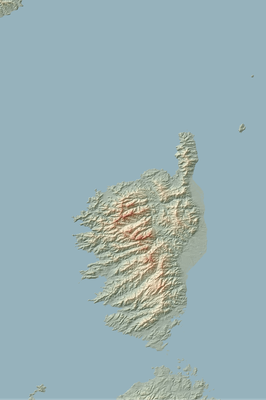

In [15]:
from PIL import Image
from IPython.display import display

im = Image.open(outfpath)
im.thumbnail((400, 400), Image.ANTIALIAS)

display(im)

Note that all sea area with no elevation are transparent.  This is because NASA doesn't have any file for it.

---

# If you want all the LandSerf scripts at once

If you have not yet executed the previous script in LandSerf (but have run the cells) and want to execute them in one pass, just run the following cell and copy/paste the output in the LandScript Editor.

In [ ]:
print("====== COPY THE FOLLOWING LINES IN THE LANDSCRIPT EDITOR ======\n")
print(script1)
print(script2)
print(script3)
print("===============================================================")